# Working Notebook for creating wndchrm features

## Step 1
### Load nessecary modules

In [1]:
# Add python modules

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from copy import deepcopy

# Add parent directory for custom modules
from sys import path as sysPath
sysPath.append('../')
sysPath.append('../Machine_Score/')

# Load custom modules that simr has loaded
import main_SIMR as simr
gm = simr.gm
im = simr.im
ic = simr.ic
fe = simr.fe
ms = simr.ms
sa = simr.sa
dc = simr.ms.dc

simr.test()
gm.test()
im.test()
ic.test()
fe.test()
ms.test()
dc.test()
sa.test()

SIMR: Hi!  You're in Matthew's main program for all things galaxy collisions
GM: Hi!  You're in Matthew's module for generally useful functions and classes
IM: Hi!  You're in Matthew's information module for SPAM
IC: Hi!  You're in Matthew's main code for all things image creation.
FE: Hi!  You're in Matthew's module for extracting feature values from images.
MS: Hi!  You're in Matthew's SIMR module for all things machine scoring images
DC: Hi!  You're in direct_image_compare.py
SA: Hi!  You're in Matthew's Main program for score analysis!


___
## Step 2
### Load Target Info class
Needed for loading the target image and running through models later.

In [2]:
tDir = '../targetDir'
tDir = gm.validPath(tDir)

tInfo = im.target_info_class( targetDir = tDir, printAll=False)
if tInfo.status == False:
    print("WARNING: target info class bad")
else:
    print("Target Good!: %s" % tInfo.get('target_id'))

# Get run info class
rInfo = tInfo.getRunInfo( rID='run_0000' )

if rInfo.status == False:
    print("WARNING")
else:
    print("Run Good!: %s"%rInfo.get('run_id'))

Target Good!: 587722984435351614
Run Good!: run_0000


___
## Step 4: Create a new image parameter


In [3]:
chimeLoc = './../param/chime_group_1.json'
chime_group_1 = gm.readJson( chimeLoc )
#gm.pprint(chime_group_1['chime_1'])

In [21]:
runsRaw = pd.read_csv( tInfo.wndRunRawLoc )
targetRaw = pd.read_csv( tInfo.wndTargetRawLoc )


In [97]:

# Function to collect model wndchrm values and normalize them.
def normalize_target_wndchrm( args, tInfo, normDict, groupParam = None ):
    
    printAll = args.printAll
    printBase = args.printBase
    
    if printBase:
        print( "FE: normalize_target_wnchrm." )
        gm.tabprint( "tID: %s" % tInfo.get( 'target_id' ) )
        gm.tabprint( "Normalization Parameters")
        gm.pprint( normDict )
        
    # Useful variables
    
    infoHeaders = [ 'run_id', 'target_id', 'image_name', 'zoo_merger_score' ]
        
    # Remove quotes later
    '''
    # target_collect_wndchrm_all_raw( args, tInfo )
    # runsRaw = pd.read_csv( tInfo.wndRunRawLoc )
    # targetRaw = pd.read_csv( tInfo.wndTargetRawLoc )
    '''
    
    if printAll:
        gm.tabprint( 'Target Shape: %s' % str( targetRaw.shape ) )
        gm.tabprint( 'Runs Shape: %s' % str( runsRaw.shape ) )
    
    
    # Combine top N models and target 
    if normDict.get( 'top_models', None) != None:
        
        topN = int( normDict['top_models'] )
        
        if printAll:
            gm.tabprint( 'top_models: %d' % topN )
        
        # Grab names of top N models
        # assume run_id is listed in alphanumerical order of best.  This will likely change later
        runIDList = list(runsRaw['run_id'].unique())[0:topN]
        
        topRunRaw = runsRaw[ runsRaw['run_id'].isin(runIDList) ]
        
        allRaw = pd.concat( [ topRunRaw, targetRaw ] )
        
        if printAll: gm.tabprint("Shape top N: %s" % str( allRaw.shape ) )
    
    # Combine all models and target.
    else:
        allRaw = pd.concat( [ runsRaw, targetRaw ] )
         
    
    # Extract only images from image_group
    if groupParam != None:
        imgNameList = [ groupParam[pKey]['imgArg']['name'] for pKey in groupParam ]
        allRaw = allRaw[ allRaw['image_name'].isin(imgNameList) ]
        
        if printAll:    gm.tabprint("Shape image group: %s" % str( allRaw.shape ) )
    
    if printAll:    gm.tabprint('All Raw Shape: %s'%str(allRaw.shape))
    
    # Headers not in info headers are assumed feature value header names
    featHeaders = [ h for h in allRaw if h not in infoHeaders ]

    # Remove any rows with nan values in feature headers
    filtRaw = allRaw[ ~allRaw[ featHeaders ].isin([np.nan, np.inf, -np.inf]).any(1)]
    if printAll:    gm.tabprint('filtered out: %s' % str(filtRaw.shape))
        
    # Seperate information columns from feature value columns being normalized.
    infoDF = filtRaw[ infoHeaders ]
    featValues = filtRaw.drop( infoHeaders, axis=1 ).values
    
    if printAll:
        gm.tabprint('info Headers: [ %s ]' % ', '.join(infoHeaders))
        gm.tabprint('feat value Shape: %s' % str(featValues.shape ) )
    
    normMethod = normDict.get( 'normalization_method', 'sklearn_StandardScaler' )
    
    if normMethod == 'sklearn_StandardScaler':
        sc = 

    
# Have Target collect wndchrm values and collect into one file

norm_wndchrm_all_test = {}
norm_wndchrm_all_test['name'] = 'norm_wndchrm_test'
norm_wndchrm_all_test['top_models'] = 500
norm_wndchrm_all_test['image_group'] = 'chime_group_1'
norm_wndchrm_all_test['normalization_method'] = 'sklearn_StandardScaler'

normLoc = '../param/' + norm_wndchrm_all_test['name'] + '.json'
gm.saveJson( norm_wndchrm_all_test, normLoc )
#gm.pprint( norm_wndchrm_all_test )

tArg = gm.inArgClass()
tArg.printAll = True

normalize_target_wndchrm( tArg, tInfo, norm_wndchrm_all_test, groupParam = chime_group_1 )

FE: normalize_target_wnchrm.
	 - tID: 587722984435351614
	 - Normalization Parameters
{'image_group': 'chime_group_1',
 'name': 'norm_wndchrm_test',
 'normalization_method': 'sklearn_StandardScaler',
 'top_models': 500}
	 - Target Shape: (1, 1062)
	 - Runs Shape: (61921, 1062)
	 - top_models: 500
	 - Shape top N: (24002, 1063)
	 - Shape image group: (24001, 1063)
	 - All Raw Shape: (24001, 1063)
	 - filtered out: (24000, 1063)
	 - info Headers: [ run_id, target_id, image_name, zoo_merger_score ]
	 - feat value Shape: (24000, 1059)


In [63]:
fe.reorganize_wndchrm_target_data( tArg, tInfo,  )

FE: reorganize_wndchrm_target_data
	 - number of features: 1059
	 - number of images: 1
	 - feature labels head: [ Chebyshev-Fourier Coefficients () [0], Chebyshev-Fourier Coefficients () [1], ... ]
	 - feature labels tail: [ ..., Zernike Coefficients (Fourier ()) [70], Zernike Coefficients (Fourier ()) [71] ]
	 - Extracted feature values dataframe
	 -  head: [ target_id, image_name, zoo_merger_score, Chebyshev-Fourier Coefficients () [0], ... ]
	 - feature labels tail: [ ..., Zernike Coefficients (Fourier ()) [70], Zernike Coefficients (Fourier ()) [71] ]
	 - Saving wndchrm data at: /home/mbo2d/587722984435351614/information/wndchrm_files/targets_raw.csv



IC: Adusting Starting Target Image

	 - From points:
[[513. 514.]
 [309. 608.]
 [607. 718.]]
	 - To points:
[[33. 50.]
 [67. 50.]
 [33. 16.]]
	 - Warp Matrix
[[-1.37477206e-01  6.33473400e-02  7.09652739e+01]
 [-6.33473400e-02 -1.37477206e-01  1.53160469e+02]]
	 - Writing to loc: /home/mbo2d/587722984435351614/information/target_images/target_chime_img_0.png
	 - File should exist: /home/mbo2d/587722984435351614/information/target_images/target_chime_img_0.png


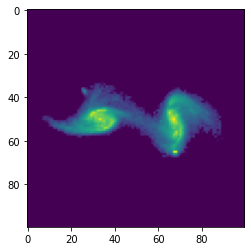

In [10]:
tImg = ic.adjustTargetImage( tInfo, chime_group_1[list(chime_group_1.keys())[0]], printAll=True, wndchrm_image=True )

#gm.pprint( chime_group_1[list(chime_group_1.keys())[0]] )
plt.imshow( tImg )

In [8]:
fe.wndchrm_target_all( gm.inArgClass(), tInfo )

	 - Collecting wndchrm all data


In [7]:
tInfo.printAll = True
tInfo.gatherRunInfos()
print("Done")

IM: Target.gatherRunInfos
	 - IM: gather_run_info LOOP: 1293 / 1293 COMPLETE
IM: Target.saveInfoFile():
	 - Saving target info file...
Done
